In [74]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('seaborn-white')
%matplotlib inline

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Helper functions
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from nhanes.utils import (one_hot_encode, 
                          precision_recall_thershold, 
                          plot_recall_vs_decision_boundary, 
                          plot_multi_recall_vs_decision_boundary,
                          plot_roc_curves,
                          plot_bootstrap_roc,
                          bootstrap_model, 
                          roc_interp,GridSearchCVWrapper)
# from sklearn.model_selection import GridSearchCV as GridSearchCVWrapper

# remove after this is resolved:
# https://stackoverflow.com/questions/36373266/change-in-running-behavior-of-sklearn-code-between-laptop-and-desktop/37259431
import warnings
warnings.filterwarnings("ignore")

%reload_ext autoreload
%autoreload 2

### Import training and test sets

In [75]:
df_train = pd.read_csv('./data/diabetes_data_train.csv')
df_test = pd.read_csv('./data/diabetes_data_test.csv')

### Check proportion of missing values

In [76]:
df_train.isnull().sum(axis=0)/df_train.shape[0]

Age                                       0.000000
Gender                                    0.000000
Race                                      0.000000
Education                                 0.045768
status                                    0.000000
Smoked at least 100 cigarettes in life    0.000395
Height                                    0.012428
WaistCircumference                        0.048728
BMI                                       0.016374
Hypertension                              0.000000
Thyroid                                   0.047347
PhysicalActivity                          0.006116
SleepDuration                             0.010258
Calories                                  0.213257
Carbs                                     0.213257
Sugar                                     0.213257
TotalFat                                  0.213257
Cholesterol                               0.213257
OCD150                                    0.000000
dtype: float64

### Impute values based on categorical or numerical data type

In [77]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder


imp_Height = df_train.Height.mean()
imp_BMI = df_train.BMI.mean()
imp_SleepDuration = df_train.SleepDuration.mean()
# EM-based imputation for BMI and Height
imputer =  KNNImputer(n_neighbors=7)


df_train[['BMI', 'Height','PhysicalActivity']] = imputer.fit_transform(df_train[['BMI', 'Height','PhysicalActivity']])
df_test[['BMI', 'Height','PhysicalActivity']] = imputer.fit_transform(df_test[['BMI', 'Height','PhysicalActivity']])

# Regression-based imputation for WaistCircumference using BMI and Height as inputs
combined = pd.concat([df_train, df_test], axis=0)

# Encode categorical columns
encoders = {}
for col in ['Education', 'Thyroid','OCD150']:
    encoder = LabelEncoder()
    combined[col] = combined[col].astype(str)
    combined[col] = encoder.fit_transform(combined[col])
    encoders[col] = encoder

# Replace NaN values with a placeholder (-1)
combined = combined.replace({'nan': -1})

# Separate back into train and test for KNNImputer
df_train_encoded = combined.iloc[:len(df_train), :]
df_test_encoded = combined.iloc[len(df_train):, :]

# Apply KNNImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imputed_combined = imp.fit_transform(pd.concat([df_train_encoded, df_test_encoded]))

# Convert back to DataFrame
imputed_combined_df = pd.DataFrame(imputed_combined, columns=df_train.columns)

# Decode imputed values back to original categories
for col in ['Education', 'Thyroid','OCD150']:
    imputed_combined_df[col] = imputed_combined_df[col].round().astype(int)
    imputed_combined_df[col] = encoders[col].inverse_transform(imputed_combined_df[col])

# Separate imputed train and test data
df_train_imputed = imputed_combined_df.iloc[:len(df_train), :].reset_index(drop=True)
df_test_imputed = imputed_combined_df.iloc[len(df_train):, :].reset_index(drop=True)

df_train['Education']= df_train_imputed['Education']
df_train['Thyroid']= df_train_imputed['Thyroid']
# df_train['OCD150']= df_train_imputed['OCD150']
df_test['Education']= df_test_imputed['Education']
df_test['Thyroid']= df_test_imputed['Thyroid']
# df_test['OCD150']= df_test_imputed['OCD150']



# Prepare the data
regression_data = df_train[['WaistCircumference', 'BMI', 'Height']].dropna()

regressor = LinearRegression()
regressor.fit(regression_data[['BMI', 'Height']], regression_data['WaistCircumference'])
missing_waist = df_train[df_train['WaistCircumference'].isnull()]
missing_waist_test = df_test[df_test['WaistCircumference'].isnull()]
predicted_waist = regressor.predict(missing_waist[['BMI', 'Height']])
predicted_waist_test = regressor.predict(missing_waist_test[['BMI', 'Height']])

regression_data_calories = df_train[['Calories', 'BMI', 'Height']].dropna()
regressor_calories = LinearRegression()
regressor_calories.fit(regression_data_calories[['BMI', 'Height']], regression_data_calories['Calories'])
missing_calories = df_train[df_train['Calories'].isnull()]
missing__calories_test = df_test[df_test['Calories'].isnull()]
predicted_calories = regressor_calories.predict(missing_calories[['BMI', 'Height']])
predicted_calories_test = regressor_calories.predict(missing__calories_test[['BMI', 'Height']])

# Prepare the data for TotalFat
regression_data_fat = df_train[['TotalFat', 'BMI', 'Height']].dropna()
regressor_fat = LinearRegression()
regressor_fat.fit(regression_data_fat[['BMI', 'Height']], regression_data_fat['TotalFat'])
missing_fat = df_train[df_train['TotalFat'].isnull()]
missing_fat_test = df_test[df_test['TotalFat'].isnull()]
predicted_fat = regressor_fat.predict(missing_fat[['BMI', 'Height']])
predicticted_fat_test = regressor_fat.predict(missing_fat_test[['BMI', 'Height']])

# Prepare the data for SleepDuration
regression_data_sleep = df_train[['SleepDuration', 'BMI', 'Height']].dropna()
regressor_sleep = LinearRegression()
regressor_sleep.fit(regression_data_sleep[['BMI', 'Height']], regression_data_sleep['SleepDuration'])
missing_sleep = df_train[df_train['SleepDuration'].isnull()]
missing_sleep_test = df_test[df_test['SleepDuration'].isnull()]
predicted_sleep = regressor_sleep.predict(missing_sleep[['BMI', 'Height']])
predicted_sleep_test = regressor_sleep.predict(missing_sleep_test[['BMI', 'Height']])

# Prepare the data for Carbs
regression_data_carbs = df_train[['Carbs', 'BMI', 'Height']].dropna()
regressor_carbs = LinearRegression()
regressor_carbs.fit(regression_data_carbs[['BMI', 'Height']], regression_data_carbs['Carbs'])
missing_carbs = df_train[df_train['Carbs'].isnull()]
missing_carbs_test = df_test[df_test['Carbs'].isnull()]
predicted_carbs = regressor_carbs.predict(missing_carbs[['BMI', 'Height']])
predicted_carbs_test = regressor_carbs.predict(missing_carbs_test[['BMI', 'Height']])

# Prepare the data for Cholesterol
regression_data_cholesterol = df_train[['Cholesterol', 'BMI', 'Height']].dropna()
regressor_cholesterol = LinearRegression()
regressor_cholesterol.fit(regression_data_cholesterol[['BMI', 'Height']], regression_data_cholesterol['Cholesterol'])
missing_cholesterol = df_train[df_train['Cholesterol'].isnull()]
missing_cholesterol_test = df_test[df_test['Cholesterol'].isnull()]
predicted_cholesterol = regressor_cholesterol.predict(missing_cholesterol[['BMI', 'Height']])
predicted_cholestrol_test = regressor_cholesterol.predict(missing_cholesterol_test[['BMI', 'Height']])

# Prepare the data for Sugar
regression_data_sugar = df_train[['Sugar', 'BMI', 'Height']].dropna()
regressor_sugar = LinearRegression()
regressor_sugar.fit(regression_data_sugar[['BMI', 'Height']], regression_data_sugar['Sugar'])
missing_sugar = df_train[df_train['Sugar'].isnull()]
missing_sugar_test = df_test[df_test['Sugar'].isnull()]
predicted_sugar = regressor_sugar.predict(missing_sugar[['BMI', 'Height']])
predicted_sugar_test = regressor_sugar.predict(missing_sugar_test[['BMI', 'Height']])

df_train.loc[df_train['WaistCircumference'].isnull(), 'WaistCircumference'] = predicted_waist
df_train.loc[df_train['Calories'].isnull(), 'Calories'] = predicted_calories
df_train.loc[df_train['TotalFat'].isnull(), 'TotalFat'] = predicted_fat
df_train.loc[df_train['SleepDuration'].isnull(), 'SleepDuration'] = predicted_sleep
df_train.loc[df_train['Carbs'].isnull(), 'Carbs'] = predicted_carbs
df_train.loc[df_train['Cholesterol'].isnull(), 'Cholesterol'] = predicted_cholesterol
df_train.loc[df_train['Sugar'].isnull(), 'Sugar'] = predicted_sugar
df_train.loc[df_train.SleepDuration.isnull(), 'SleepDuration'] = imp_SleepDuration
df_train.loc[df_train['Smoked at least 100 cigarettes in life'].isnull(), 'Smoked at least 100 cigarettes in life'] = 2



df_test.loc[df_test['WaistCircumference'].isnull(), 'WaistCircumference'] = predicted_waist_test
df_test.loc[df_test['Calories'].isnull(), 'Calories'] = predicted_calories_test
df_test.loc[df_test['TotalFat'].isnull(), 'TotalFat'] = predicticted_fat_test
df_test.loc[df_test['SleepDuration'].isnull(), 'SleepDuration'] = predicted_sleep_test
df_test.loc[df_test['Carbs'].isnull(), 'Carbs'] = predicted_carbs_test
df_test.loc[df_test['Cholesterol'].isnull(), 'Cholesterol'] = predicted_cholestrol_test
df_test.loc[df_test['Sugar'].isnull(), 'Sugar'] = predicted_sugar_test
df_test.loc[df_test.SleepDuration.isnull(), 'SleepDuration'] = imp_SleepDuration
df_test.loc[df_test['Smoked at least 100 cigarettes in life'].isnull(), 'Smoked at least 100 cigarettes in life'] = 2

In [78]:
df_train.isnull().sum(axis=0)/df_train.shape[0]
df_test.isnull().sum(axis=0)/df_test.shape[0]

Age                                       0.0
Gender                                    0.0
Race                                      0.0
Education                                 0.0
status                                    0.0
Smoked at least 100 cigarettes in life    0.0
Height                                    0.0
WaistCircumference                        0.0
BMI                                       0.0
Hypertension                              0.0
Thyroid                                   0.0
PhysicalActivity                          0.0
SleepDuration                             0.0
Calories                                  0.0
Carbs                                     0.0
Sugar                                     0.0
TotalFat                                  0.0
Cholesterol                               0.0
OCD150                                    0.0
dtype: float64

### One-hot-encode categorical/ordinal variables

In [79]:
continuous_cols = ['Age', 'Height', 'WaistCircumference', 'BMI', 
                  'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 
                  'SleepDuration', 'PhysicalActivity']


# Get categorical columns (those not in continuous_cols)
Y_train = df_train['status']
Y_test = df_test['status']

df_train.drop(['status'], axis=1, inplace=True) 
df_test.drop(['status'], axis=1, inplace=True)


categorical_cols = [col for col in df_train.columns if col not in continuous_cols ]
print(continuous_cols)
print(categorical_cols)
X_train_categorical = pd.concat(map(lambda col: one_hot_encode(df_train[col], col), categorical_cols), 
                                axis=1)
X_test_categorical = pd.concat(map(lambda col: one_hot_encode(df_test[col], col), categorical_cols),axis=1)

['Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration', 'PhysicalActivity']
['Gender', 'Race', 'Education', 'Smoked at least 100 cigarettes in life', 'Hypertension', 'Thyroid', 'OCD150']


In [80]:
X_train_onehot = pd.concat([X_train_categorical, df_train[continuous_cols]], axis=1)
X_test_onehot = pd.concat([X_test_categorical, df_test[continuous_cols]], axis=1)

In [81]:
train_cols = X_train_onehot.columns

In [82]:
print(X_train_onehot.shape)
print(X_train_onehot.columns)
# print(X_train_onehot.status)

(5069, 40)
Index(['Gender_2.0', 'Gender_nan', 'Race_2.0', 'Race_3.0', 'Race_4.0',
       'Race_6.0', 'Race_7.0', 'Race_nan', 'Education_2.0', 'Education_3.0',
       'Education_4.0', 'Education_5.0', 'Education_nan', 'Education_nan',
       'Smoked at least 100 cigarettes in life_2.0',
       'Smoked at least 100 cigarettes in life_7.0',
       'Smoked at least 100 cigarettes in life_9.0',
       'Smoked at least 100 cigarettes in life_nan', 'Hypertension_2.0',
       'Hypertension_9.0', 'Hypertension_nan', 'Thyroid_2.0', 'Thyroid_nan',
       'Thyroid_nan', 'OCD150_2.0', 'OCD150_3.0', 'OCD150_4.0', 'OCD150_9.0',
       'OCD150_nan', 'Age', 'Height', 'WaistCircumference', 'BMI', 'Calories',
       'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration',
       'PhysicalActivity'],
      dtype='object')


In [83]:
categorical_cols = [c for c in train_cols if c not in continuous_cols]
categorical_cols = [col for col in categorical_cols if col not in ['Smoked at least 100 cigarettes in life_9.0', 'OCD150_9.0']]
print(categorical_cols)

['Gender_2.0', 'Gender_nan', 'Race_2.0', 'Race_3.0', 'Race_4.0', 'Race_6.0', 'Race_7.0', 'Race_nan', 'Education_2.0', 'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_nan', 'Education_nan', 'Smoked at least 100 cigarettes in life_2.0', 'Smoked at least 100 cigarettes in life_7.0', 'Smoked at least 100 cigarettes in life_nan', 'Hypertension_2.0', 'Hypertension_9.0', 'Hypertension_nan', 'Thyroid_2.0', 'Thyroid_nan', 'Thyroid_nan', 'OCD150_2.0', 'OCD150_3.0', 'OCD150_4.0', 'OCD150_nan']


### SMOTE


In [84]:

from imblearn.over_sampling import SMOTE

df_train.isnull().sum(axis=0)/df_train.shape[0]




smote = SMOTE(sampling_strategy='minority',random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_onehot, Y_train)

X_test_resampled, y_test_resampled = smote.fit_resample(X_test_onehot, Y_test)
scale = MinMaxScaler(feature_range=(0, 1)).fit(X_train_resampled[continuous_cols])
X_train_cont_scaled = pd.DataFrame(scale.transform(X_train_resampled[continuous_cols]),
                                   index=X_train_resampled.index,
                                   columns=continuous_cols)
X_test_cont_scaled = pd.DataFrame(scale.transform(X_test_resampled[continuous_cols]),
                                  index=X_test_resampled.index,
                                  columns=continuous_cols)
X_train_scale = pd.concat([X_train_cont_scaled, X_train_resampled[categorical_cols]], axis=1)
X_test_scale = pd.concat([X_test_cont_scaled, X_test_resampled[categorical_cols]], axis=1)

print(X_train_scale.shape,y_train_resampled.shape) #FINAL X AND Y
print(X_test_scale.shape,y_test_resampled.shape)

(8630, 42) (8630,)
(2152, 42) (2152,)


### Feature Seletion

['Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration', 'PhysicalActivity', 'Gender_2.0', 'Gender_nan', 'Race_2.0', 'Race_3.0', 'Race_4.0', 'Race_6.0', 'Race_7.0', 'Race_nan', 'Education_2.0', 'Education_3.0', 'Education_4.0', 'Education_5.0', 'Education_nan', 'Education_nan', 'Education_nan', 'Education_nan', 'Smoked at least 100 cigarettes in life_2.0', 'Smoked at least 100 cigarettes in life_7.0', 'Smoked at least 100 cigarettes in life_nan', 'Hypertension_2.0', 'Hypertension_9.0', 'Hypertension_nan', 'Thyroid_2.0', 'Thyroid_nan', 'Thyroid_nan', 'Thyroid_nan', 'Thyroid_nan', 'OCD150_2.0', 'OCD150_3.0', 'OCD150_4.0', 'OCD150_nan']
Selected features: ['Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration', 'PhysicalActivity', 'Gender_2.0', 'Race_3.0', 'Education_3.0', 'Education_4.0', 'Education_5.0', 'Smoked at least 100 cigarettes in life_2.0', 'Hypertensi

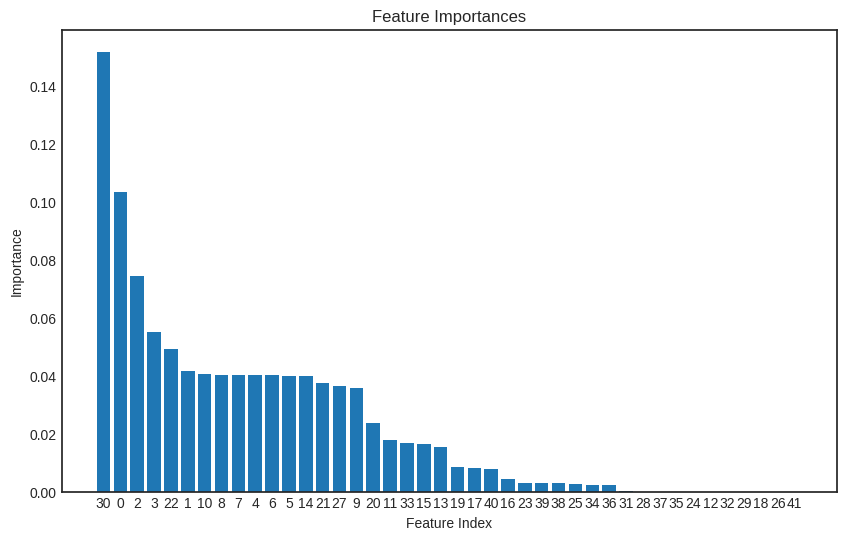

In [85]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import numpy as np

# PCA transformation
# pca = PCA(n_components=0.95)  
X_train_pca = X_train_scale.copy()
X_test_pca = X_test_scale.copy()

# PCA visualization

# Feature selection
selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42), 
    max_features=19,
    threshold=-np.inf
)
selector.fit(X_train_pca, y_train_resampled)

# Print selected feature names (PCA components)
selected_indices = selector.get_support(indices=True)
print( list(X_train_pca))
selected_feature_names = [X_train_pca.columns[i] for i in selected_indices]
print("Selected features:", selected_feature_names)

# Feature importance visualization
importances = selector.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Transform datasets
selected_features = selector.transform(X_train_pca)
selected_features_test = selector.transform(X_test_pca)




In [86]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with more conservative values to avoid overfitting
param_grid = {
    'C': [1.0],  # Lower C values to reduce overfitting
    'kernel': ['rbf'],    # Focus on most common kernels
    'gamma': [1.0],     # Standard gamma values
    'class_weight': ['balanced', None]  # Add class weights to handle imbalance
}

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(
    SVC(probability=True, random_state=42), 
    param_grid,
    cv=5,                      # 5-fold cross-validation
    scoring='balanced_accuracy', # Use balanced accuracy for imbalanced classes
    n_jobs=-1,                # Use all available cores
    verbose=1
)

# Fit the model
grid_search.fit(selected_features, y_train_resampled)

# Get the best parameters and score
svc_best_params = grid_search.best_params_
svc_best_score = grid_search.best_score_

print("Best parameters:", svc_best_params)
print("Best cross-validation score:", svc_best_score)

# Train the final model with the best parameters
svc_clf = SVC(**svc_best_params, probability=True).fit(selected_features, y_train_resampled)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf'}
Best cross-validation score: 0.8500579374275782


Accuracy: 0.8322490706319703
Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.84      0.83      1076
         1.0       0.84      0.82      0.83      1076

    accuracy                           0.83      2152
   macro avg       0.83      0.83      0.83      2152
weighted avg       0.83      0.83      0.83      2152

Confusion Matrix:
 [[907 169]
 [192 884]]


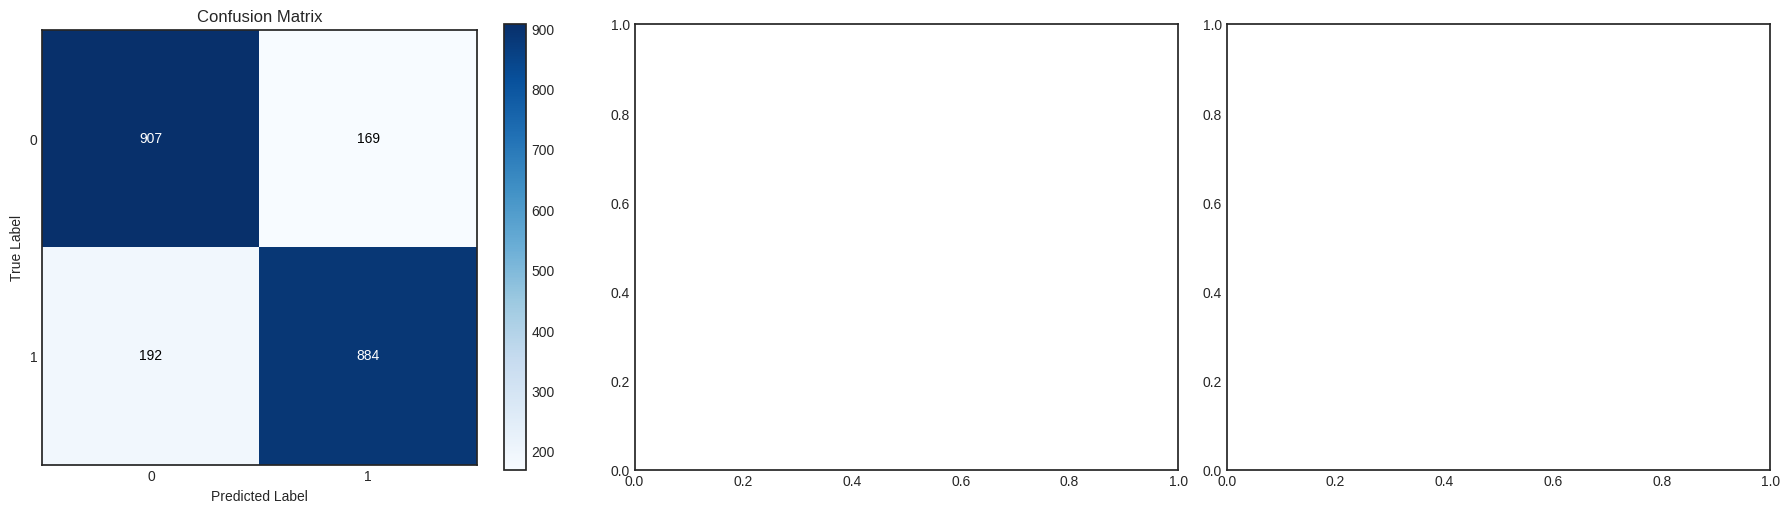

In [112]:
import numpy as np
from sklearn import metrics

# Predict the labels for the test set
y_pred = svc_clf.predict(selected_features_test)

# Evaluate the performance
accuracy = metrics.accuracy_score(y_test_resampled, y_pred)
classification_report = metrics.classification_report(y_test_resampled, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test_resampled, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report)

print("Confusion Matrix:\n", confusion_matrix)
# Import necessary modules
import matplotlib.pyplot as plt

# Compute additional performance metrics
f1 = metrics.f1_score(y_test_resampled, y_pred)
precision = metrics.precision_score(y_test_resampled, y_pred)

# Create a figure with three subplots: one for the confusion matrix,
# one for the F1-score and one for the Precision score.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# -------------------
# Plot the Confusion Matrix
# -------------------
cm = confusion_matrix  # already computed
im = axes[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
axes[0].set_title("Confusion Matrix")
plt.colorbar(im, ax=axes[0])
# Define the class names (assuming binary classification: 0 and 1)
class_names = ['0', '1']
tick_marks = np.arange(len(class_names))
axes[0].set_xticks(tick_marks)
axes[0].set_xticklabels(class_names)
axes[0].set_yticks(tick_marks)
axes[0].set_yticklabels(class_names)
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Annotate each cell with its value
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        axes[0].text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

# --------
plt.tight_layout()
plt.show()


### RandomForest

Best Params: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_jobs': -1}
Best Score: 0.873
Random Forest Accuracy: 0.849907063197026


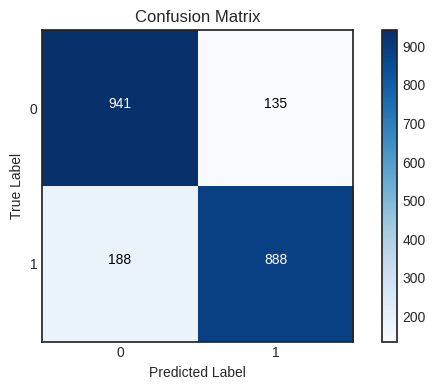

In [113]:
import numpy as np

rf_best_params, rf_best_score = GridSearchCVWrapper(
    model=RandomForestClassifier(),
    param_grid=dict(
        criterion=["entropy"],
        min_samples_leaf=[10,15],
        min_samples_split=[2,4],
        max_features=["sqrt"],
        n_jobs=[-1],
    ),
   
    X=selected_features,
    y=y_train_resampled
)
# Fit the RandomForest model using the best parameters obtained from GridSearchCVWrapper
rf_clf = RandomForestClassifier(**rf_best_params).fit(selected_features, y_train_resampled)

# Predict on the test set
y_pred_rf = rf_clf.predict(selected_features_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test_resampled, y_pred_rf)
print("Random Forest Accuracy:", accuracy)

# Print the confusion matrix
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_rf)

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

# max_depths = np.linspace(20, 30, 50, endpoint=True)
# max_estimators = np.linspace(40, 60, 50, endpoint=True)

# train_results = []
# test_results = []

# for max_depth in max_depths:
#     for n_estimators in max_estimators:
#         rf = RandomForestClassifier(max_depth= int(max_depth), **rf_best_params)
#         rf.fit(selected_features, y_train_resampled)
        
#         train_pred = rf.predict(selected_features)
#         train_accuracy = metrics.accuracy_score(y_train_resampled, train_pred)
#         train_results.append(train_accuracy)
        
#         test_pred = rf.predict(selected_features_test)
#         test_accuracy = metrics.accuracy_score(y_test_resampled, test_pred)
#         test_results.append(test_accuracy)

# plt.figure(figsize=(10, 6))
# plt.plot(max_depths, train_results, label='Train Accuracy')
# plt.plot(max_depths, test_results, label='Test Accuracy')
# plt.xlabel('Max Depth')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Train and Test Accuracy over Max Depth')
# plt.show()

### LogisticRegression

/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'.

Best Params: {'C': 10.0, 'l1_ratio': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.851
Logistic Regression Accuracy: 0.8294609665427509


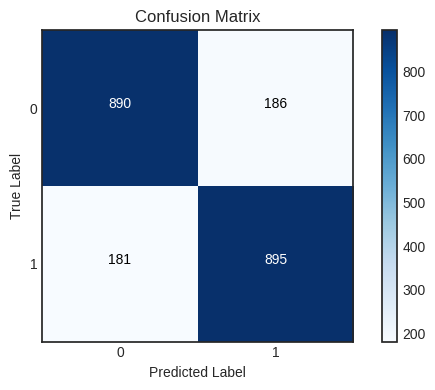

In [115]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel


lg_best_params, lg_best_score = GridSearchCVWrapper(
    model=LogisticRegression(),
    param_grid=dict(
        penalty=["elasticnet","l2"],
        l1_ratio=[0.5,0.3,0.7],
        C=[0.001, 0.01, 0.1, 1.0, 10.0],  # Add a range of C values for tuning
        solver=['lbfgs', 'liblinear', 'newton-cholesky']     # Add different solvers for tuning
    ),
    X=selected_features,
    y=y_train_resampled
)

lg_clf = LogisticRegression(**lg_best_params).fit(selected_features, y_train_resampled)

# Predict on the test set
y_pred_rf = lg_clf.predict(selected_features_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test_resampled, y_pred_rf)
print("Logistic Regression Accuracy:", accuracy)

# Print the confusion matrix
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_rf)

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()



### KNN

Best Params: {'n_neighbors': 11}
Best Score: 0.849
KNN Accuracy: 0.828996282527881


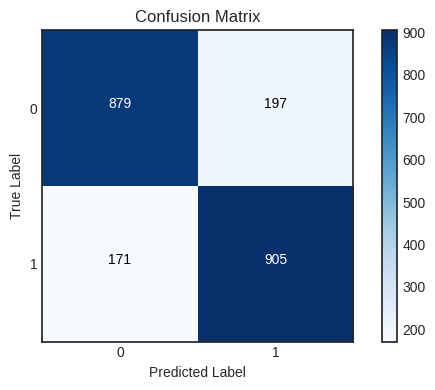

In [116]:
knn_best_params, knn_best_score = GridSearchCVWrapper(
    model=KNeighborsClassifier(),
    param_grid=dict(
        n_neighbors=[11,13,17,23,31,41,53,97]
    ),
    X=selected_features,
    y=y_train_resampled
)


knn_clf = KNeighborsClassifier(**knn_best_params).fit(selected_features, y_train_resampled)

# Predict on the test set
y_pred_rf = knn_clf.predict(selected_features_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test_resampled, y_pred_rf)
print("KNN Accuracy:", accuracy)

# Print the confusion matrix
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_rf)

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()



### GradientBoosting

Best Params: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.865
Gradient Boosting Classifier Accuracy: 0.8652416356877324


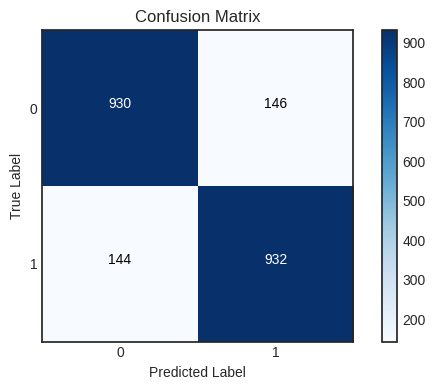

In [117]:
gbc_best_params, gbc_best_score = GridSearchCVWrapper(
    model=GradientBoostingClassifier(),
    param_grid=dict(
        loss=["log_loss"],
        learning_rate=[0.1],
        n_estimators=[100],
        max_depth=[3],
        min_samples_split=[2],
        min_samples_leaf=[1],
        max_features=["sqrt"]
    ),
    X=selected_features,
    y=y_train_resampled
)



gbc_clf = GradientBoostingClassifier(**gbc_best_params).fit(selected_features, y_train_resampled)

# Predict on the test set
y_pred_rf = gbc_clf.predict(selected_features_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test_resampled, y_pred_rf)
print("Gradient Boosting Classifier Accuracy:", accuracy)

# Print the confusion matrix
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_rf)

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


### Assess Tradeoff between Recall and the Decision Threshold (T)

In [118]:
gbc = GradientBoostingClassifier(**gbc_best_params)
gbc_clf = gbc.fit(selected_features, y_train_resampled)
gbc_proba = gbc_clf.predict_proba(selected_features_test)[:, 1]
print(gbc_proba.shape)

t_precision_nodiab, t_precision_diab, t_recall_nodiab, t_recall_diab = precision_recall_thershold(gbc_proba, y_test_resampled)

print(y_test_resampled)

print(t_recall_nodiab ,"\n" ,t_recall_diab)

(2152,)
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2147    1.0
2148    1.0
2149    1.0
2150    1.0
2151    1.0
Name: status, Length: 2152, dtype: float64
[0.0, 0.0027881040892193307, 0.05855018587360595, 0.13475836431226765, 0.2100371747211896, 0.26301115241635686, 0.2992565055762082, 0.33178438661710036, 0.37267657992565056, 0.4024163568773234, 0.43866171003717475, 0.4637546468401487, 0.4879182156133829, 0.5046468401486989, 0.5185873605947955, 0.5315985130111525, 0.5455390334572491, 0.5576208178438662, 0.5715613382899628, 0.5836431226765799, 0.595724907063197, 0.6087360594795539, 0.620817843866171, 0.6338289962825279, 0.6468401486988847, 0.6552044609665427, 0.6672862453531598, 0.6775092936802974, 0.6923791821561338, 0.6988847583643123, 0.7156133828996283, 0.7230483271375465, 0.7323420074349443, 0.7407063197026023, 0.75, 0.7565055762081785, 0.766728624535316, 0.7732342007434945, 0.7862453531598513, 0.7955390334572491, 0.8020446096654275, 0.8113382899628253,

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/home/dhruv/anaconda3/envs/RL/lib/python3.8/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and w

Best parameters: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validation score: 0.8786790266512167
Adaboost Classifier Accuracy: 0.8931226765799256


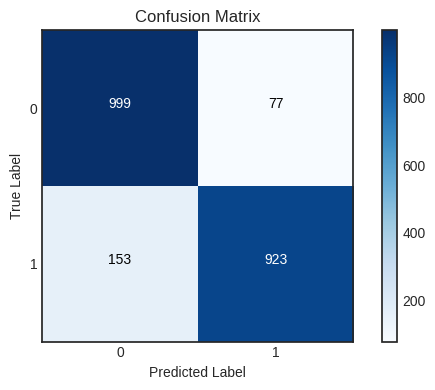

In [120]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [ 200],
    'learning_rate': [0.1],
    'base_estimator__max_depth': [3]
}

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=42), random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(selected_features, y_train_resampled)

# Get the best parameters and score
ada_best_params = grid_search.best_params_
ada_best_score = grid_search.best_score_

print("Best parameters:", ada_best_params)
print("Best cross-validation score:", ada_best_score)

# Train the final model with the best parameters
ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=ada_best_params['base_estimator__max_depth'], random_state=42),
    n_estimators=ada_best_params['n_estimators'],
    learning_rate=ada_best_params['learning_rate'],
    random_state=42
).fit(selected_features, y_train_resampled)

# Predict probabilities for the test set
# ada_proba = ada_clf.predict_proba(selected_features_test)[:, 1]



# ada_clf = AdaBoostClassifier(**ada_best_params).fit(selected_features, y_train_resampled)

# Predict on the test set
y_pred_rf = ada_clf.predict(selected_features_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test_resampled, y_pred_rf)
print("Adaboost Classifier Accuracy:", accuracy)

# Print the confusion matrix
import matplotlib.pyplot as plt

conf_matrix = metrics.confusion_matrix(y_test_resampled, y_pred_rf)

plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()


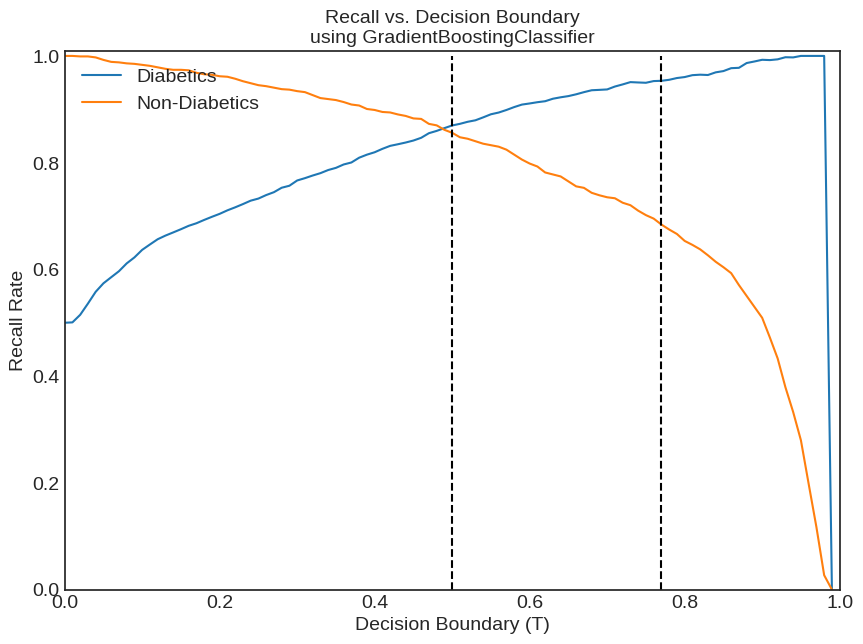

In [121]:
plot_recall_vs_decision_boundary(t_precision_diab, t_recall_diab)

### Performance Metrics 

In [122]:
threshold = .499

In [123]:
rf_clf = RandomForestClassifier(**rf_best_params).fit(selected_features, y_train_resampled)
knn_clf = KNeighborsClassifier(**knn_best_params).fit(selected_features, y_train_resampled)
lg_clf = LogisticRegression(**lg_best_params).fit(selected_features, y_train_resampled)


In [124]:
rf_proba  = rf_clf.predict_proba(selected_features_test)
knn_proba = knn_clf.predict_proba(selected_features_test)
lg_proba  = lg_clf.predict_proba(selected_features_test)
svc_proba = svc_clf.predict(selected_features_test)

In [148]:
import numpy as np
from IPython.display import Markdown, display
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Create Ensemble

# print(lg_proba)
# print(gbc_proba)
gbc_proba = gbc_clf.predict_proba(selected_features_test)
svc_proba = svc_clf.predict_proba(selected_features_test)
# print(gbc_proba)
# svc_proba = np.column_stack((svc_proba, 1 - svc_proba))
ada_proba = ada_clf.predict_proba(selected_features_test)

df_preds = pd.DataFrame({
    'RandomForestClassifier': rf_proba[:,1],
    'GradientBoostingClassifier': gbc_proba[:,1],
    'AdaBoost': ada_proba[:,1]
})

# Give more weight to AdaBoost (50%) and less weight to the other two (25% each)
df_preds.loc[:,'Ensemble'] = (0.12 * df_preds['RandomForestClassifier'] +
                               0.23 * df_preds['GradientBoostingClassifier'] +
                               0.65  * df_preds['AdaBoost'])





In [149]:
for col in df_preds:
    print(col)
    print(metrics.classification_report(y_test_resampled, np.where(1 - df_preds.loc[:,col] > threshold, 0, 1)))

RandomForestClassifier
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      1076
         1.0       0.86      0.82      0.84      1076

    accuracy                           0.84      2152
   macro avg       0.84      0.84      0.84      2152
weighted avg       0.84      0.84      0.84      2152

GradientBoostingClassifier
              precision    recall  f1-score   support

         0.0       0.86      0.87      0.86      1076
         1.0       0.87      0.85      0.86      1076

    accuracy                           0.86      2152
   macro avg       0.86      0.86      0.86      2152
weighted avg       0.86      0.86      0.86      2152

AdaBoost
              precision    recall  f1-score   support

         0.0       0.86      0.93      0.90      1076
         1.0       0.92      0.85      0.89      1076

    accuracy                           0.89      2152
   macro avg       0.89      0.89      0.89      2152
weighted avg   

# ROC Curve

RandomForestClassifier
  AUC: 0.926
GradientBoostingClassifier
  AUC: 0.938
AdaBoost
  AUC: 0.953
Ensemble
  AUC: 0.948


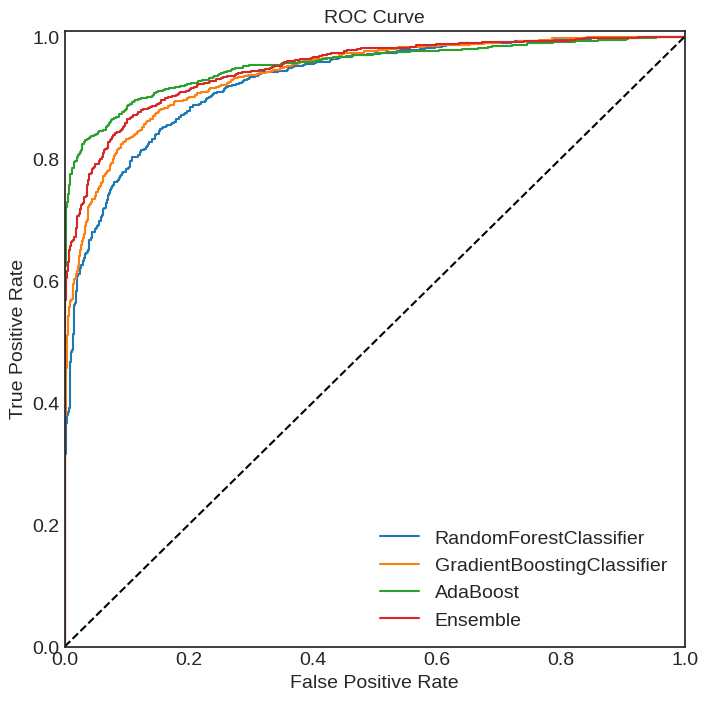

In [150]:
plot_roc_curves(df_preds, y_test_resampled)

### Bootstrap ROC Curve for GradientBoostingClassifier

In [151]:
# Warning: bootstraping may take a while
results = bootstrap_model(
    ada_clf,
    pd.DataFrame(selected_features), 
    pd.DataFrame(y_train_resampled), 
    pd.DataFrame(selected_features_test), 
    pd.DataFrame(y_test_resampled),
    10,   # change the number of bootstraps here
    0.5
)

# Calculate accuracy from results
print(results)
accuracies = [metrics.accuracy_score(r['y_test'], r['y_pred']) for r in results['results']]
print("Accuracies from bootstrap results:", accuracies)


{'recall': [0.8578066914498141, 0.8531598513011153, 0.8578066914498141, 0.8382899628252788, 0.8429368029739777, 0.8410780669144982, 0.8475836431226765, 0.8605947955390335, 0.8131970260223048, 0.8447955390334573], 'precision': [0.922077922077922, 0.9089108910891089, 0.9084645669291339, 0.9065326633165829, 0.9152371342078708, 0.9141414141414141, 0.9202825428859738, 0.9150197628458498, 0.9143155694879833, 0.9126506024096386], 'fscore': [0.888781896966779, 0.8801534036433366, 0.8824091778202677, 0.87107677450507, 0.8776003870343494, 0.8760890609874152, 0.8824383164005805, 0.8869731800766284, 0.8607968519429414, 0.8774131274131275], 'accuracy': [0.8926579925650557, 0.8838289962825279, 0.8856877323420075, 0.8759293680297398, 0.8824349442379182, 0.8810408921933085, 0.8870817843866171, 0.8903345724907064, 0.8684944237918215, 0.8819702602230484], 'fpr_tpr': [(array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e

In [102]:
# print(results)
total_auc = []
for r in results['fpr_tpr']:
    total_auc.append(metrics.auc(r[0], r[1]))



print("Accuracies from bootstrap results:", np.mean(accuracies))

Accuracies from bootstrap results: 0.8832713754646839


### Bootstrap mean and empirical confidence intervals

In [103]:
np.mean(total_auc)

0.9425759386962589

In [104]:
pd.Series(total_auc).quantile([.025, .975])

0.025    0.932875
0.975    0.952184
dtype: float64

### Bootstrap ROC curve

In [105]:
df_interp = pd.DataFrame(roc_interp(results['fpr_tpr'])).T

In [106]:
m = df_interp.mean(axis=1).values.tolist()
ci = df_interp.quantile([.025, .975], axis=1).values.tolist()

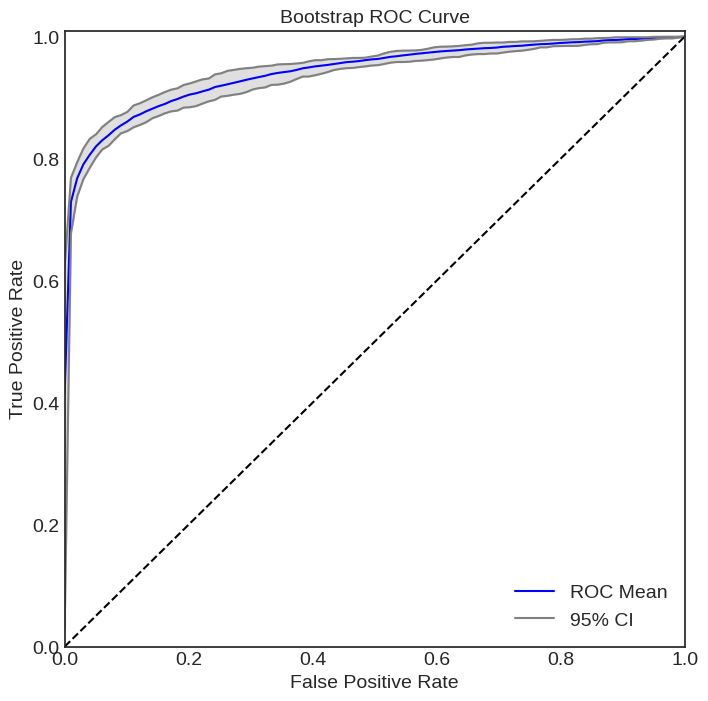

In [107]:
plot_bootstrap_roc(m, ci)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 50/50 [07:57<00:00,  9.55s/it]


Feature names: ['Age', 'Height', 'WaistCircumference', 'BMI', 'Calories', 'Carbs', 'Sugar', 'TotalFat', 'Cholesterol', 'SleepDuration', 'PhysicalActivity', 'Gender_2.0', 'Gender_nan', 'Race_2.0', 'Race_3.0', 'Race_4.0', 'Race_6.0', 'Race_7.0', 'Race_nan']


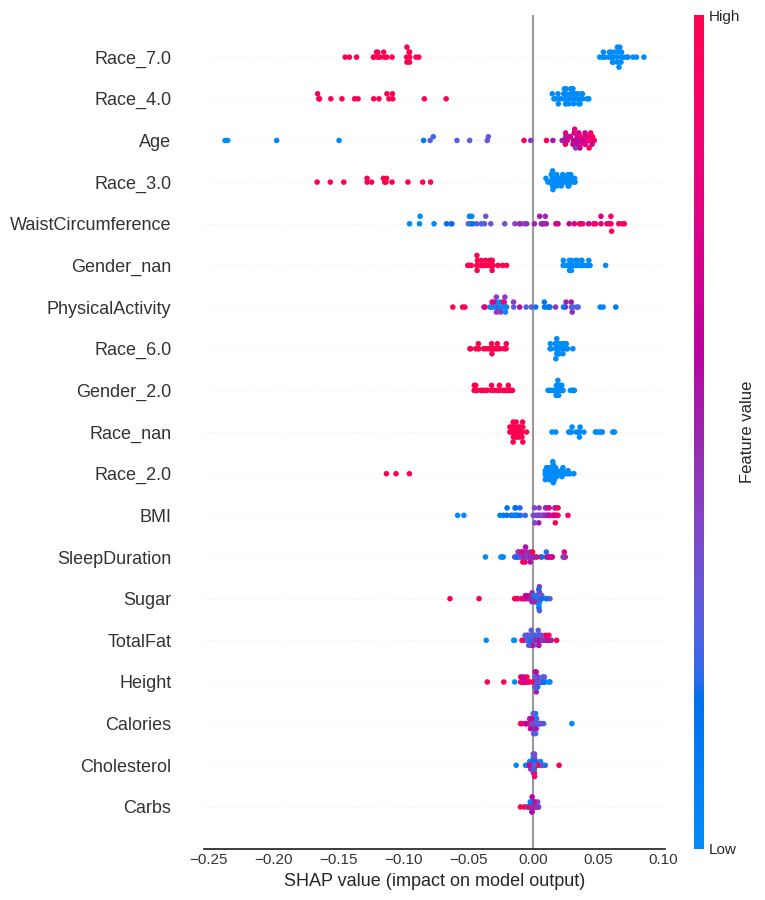

In [108]:
import shap
import numpy as np

# 1. Define an ensemble wrapper class
class EnsembleModel:
    def __init__(self, models):
        """
        models: a list of fitted classifiers that implement .predict_proba(X)
        """
        self.models = models
    
    def predict_proba(self, X):
        """Return the average predicted probability across all models."""
        ensemble_probas = [m.predict_proba(X) for m in self.models]
        return np.mean(ensemble_probas, axis=0)


# 2. Instantiate your ensemble model 
ensemble_clf = EnsembleModel([
    rf_clf,      # RandomForest
    # knn_clf,     # KNN
    # lg_clf,      # LogisticRegression
    # svc_clf,     # SVC
    gbc_clf,     # GradientBoosting
    ada_clf      # AdaBoost
])

# 3. Create a small "background" sample for KernelExplainer
np.random.seed(42)
background_size = 200
if selected_features.shape[0] > background_size:
    background_idx = np.random.choice(
        selected_features.shape[0], background_size, replace=False
    )
    background_data = selected_features[background_idx]
else:
    background_data = selected_features

# 4. Initialize the KernelExplainer
explainer = shap.KernelExplainer(
    model=ensemble_clf.predict_proba,
    data=background_data,
)

# 5. Choose a subset of test data
test_sample_size = 50
if selected_features_test.shape[0] > test_sample_size:
    test_idx = np.random.choice(
        selected_features_test.shape[0], test_sample_size, replace=False
    )
    X_test_sample = selected_features_test[test_idx]
else:
    X_test_sample = selected_features_test

# 6. Compute the SHAP values
shap_values = explainer.shap_values(X_test_sample)

# 7. (Optional) Provide feature names
# selected_feature_names = [ for i in selected_indices]

feature_names = [X_train_pca.columns[i] for i in range(X_test_sample.shape[1])]

# Print the feature names
print("Feature names:", feature_names)

# 8. Plot summary for the positive class
shap.summary_plot(
    shap_values[1], 
    X_test_sample, 
    feature_names=feature_names
)
